In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os

# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [6]:
# Set paths
data_dir = r"C:\Users\USER\Downloads\archive (5)"  # e.g., "./brain_tumor_data"
train_dir = os.path.join(data_dir, "Training")
test_dir = os.path.join(data_dir, "Testing")

# Image transforms
IMG_SIZE = 224
BATCH_SIZE = 32

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale → RGB (for pretrained models)
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

# For test/val: no augmentation
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

# Create validation split from train (80/20)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    train_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

# Update val_dataset transform (no augmentation)
val_dataset.dataset.transform = test_transform

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Class names
class_names = train_dataset.dataset.classes
print("Classes:", class_names)

Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [8]:
# Load pretrained ResNet18
model = models.resnet18(weights='IMAGENET1K_V1')

# Replace final layer for 4 classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 4)

# Move to GPU
model = model.to(device)

# Loss & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\USER/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:11<00:00, 4.14MB/s]


In [10]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 30)

        # Training phase
        model.train()
        running_loss = 0.0
        corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = corrects.double() / len(train_loader.dataset)
        train_acc_history.append(epoch_acc.item())
        train_loss_history.append(epoch_loss)

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_corrects.double() / len(val_loader.dataset)
        val_acc_history.append(val_epoch_acc.item())
        val_loss_history.append(val_epoch_loss)

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        print(f'Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}\n')

    return train_acc_history, val_acc_history, train_loss_history, val_loss_history

In [12]:
num_epochs = 20
history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

# Save model
torch.save(model.state_dict(), "brain_tumor_resnet18.pth")

Epoch 1/20
------------------------------
Train Loss: 0.3589 Acc: 0.8761
Val Loss: 0.9313 Acc: 0.7297

Epoch 2/20
------------------------------
Train Loss: 0.1788 Acc: 0.9365
Val Loss: 0.4286 Acc: 0.8915

Epoch 3/20
------------------------------
Train Loss: 0.1183 Acc: 0.9606
Val Loss: 0.1660 Acc: 0.9563

Epoch 4/20
------------------------------
Train Loss: 0.0957 Acc: 0.9661
Val Loss: 0.1872 Acc: 0.9361

Epoch 5/20
------------------------------
Train Loss: 0.0806 Acc: 0.9757
Val Loss: 0.2110 Acc: 0.9248

Epoch 6/20
------------------------------
Train Loss: 0.0489 Acc: 0.9831
Val Loss: 0.1578 Acc: 0.9440

Epoch 7/20
------------------------------
Train Loss: 0.0461 Acc: 0.9834
Val Loss: 0.1080 Acc: 0.9720

Epoch 8/20
------------------------------
Train Loss: 0.0644 Acc: 0.9779
Val Loss: 1.7921 Acc: 0.6334

Epoch 9/20
------------------------------
Train Loss: 0.0373 Acc: 0.9866
Val Loss: 0.1963 Acc: 0.9388

Epoch 10/20
------------------------------
Train Loss: 0.0360 Acc: 0.9884

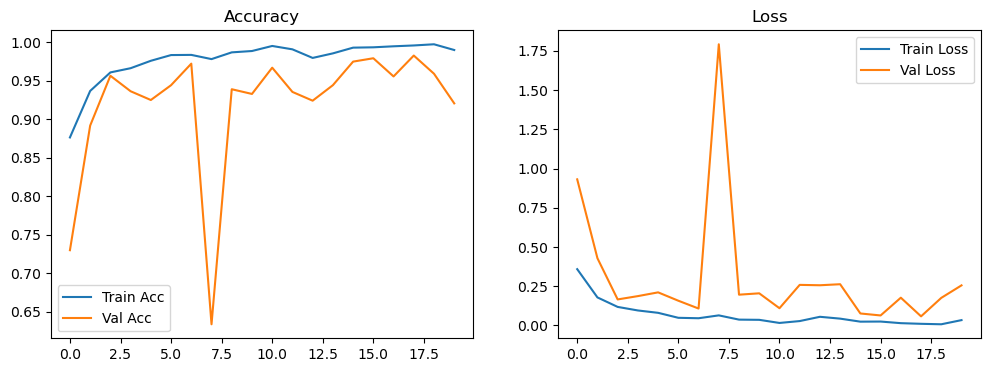

In [13]:
train_acc, val_acc, train_loss, val_loss = history

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [16]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')

Test Accuracy: 92.45%


In [26]:
from PIL import Image

def predict_image(image_path, model, class_names, device):
    img = Image.open(image_path).convert('L')  # Grayscale
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        prob = torch.softmax(output, dim=1)
        pred_idx = torch.argmax(prob, dim=1).item()
        confidence = prob[0][pred_idx].item()
    
    return class_names[pred_idx], confidence

# Example
pred_class, conf = predict_image(r"C:\Users\USER\Downloads\archive (5)\Testing\notumor\Te-no_0147.jpg", model, class_names, device)
print(f"Prediction: {pred_class} ({conf:.2%} confidence)")

Prediction: notumor (100.00% confidence)


📋 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      glioma       0.99      0.85      0.92       300
  meningioma       0.93      0.85      0.89       306
     notumor       0.95      0.98      0.96       405
   pituitary       0.84      1.00      0.91       300

    accuracy                           0.92      1311
   macro avg       0.93      0.92      0.92      1311
weighted avg       0.93      0.92      0.92      1311



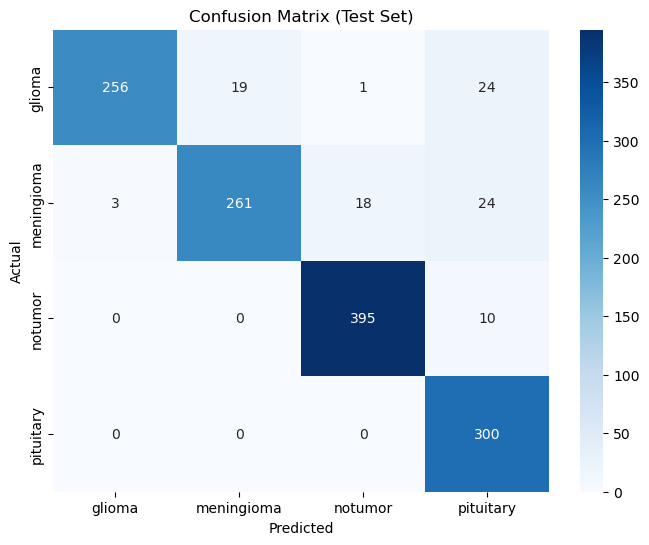

In [28]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you collected all_preds and all_labels during test
# (If not, here's how to get them)

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Get class names
class_names = test_dataset.classes  # or ['glioma', 'meningioma', 'notumor', 'pituitary']

# 📋 Classification Report
print("📋 CLASSIFICATION REPORT:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# 🎯 Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()